In [1]:
import torch
from resnet import resnet18_custom
# from torchvision.models.quantization import resnet18 as load_resnet18
# from torchvision.models.quantization import ResNet18_QuantizedWeights
from concrete.ml.torch.compile import compile_torch_model


# Load the ResNet18 model without pretrained weights
resnet18 = resnet18_custom(pretrained=True)

# # Step 1: Initialize model with the best available weights
# weights = ResNet18_QuantizedWeights.DEFAULT
# resnet18 = load_resnet18(weights=weights, quantize=True)
# resnet18.eval()


/home/ubuntu/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# Define a dummy input tensor with the size of 1x3x224x224 (batch size x channels x height x width)
dummy_input = torch.randn(10, 3, 224, 224)

# Set the model to evaluation mode
resnet18.eval()

# Path to save the ONNX model
onnx_model_path = "resnet18.onnx"

# Export the model to ONNX format
torch.onnx.export(resnet18, dummy_input, onnx_model_path, verbose=False)

onnx_model_path

'resnet18.onnx'

In [3]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
from io import BytesIO

import requests
import torch
from PIL import Image
from torchvision import models, transforms


# Read the ImageNet classes file and create a list
with open("./imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]


# Create a dictionary to map class names to indices
class_to_index = {cls: idx for idx, cls in enumerate(imagenet_classes)}


transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Download an example image from the web
image_urls = [
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01614925_bald_eagle.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01697457_African_crocodile.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01592084_chickadee.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01601694_water_ouzel.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01739381_vine_snake.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01806567_quail.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01917289_brain_coral.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02077923_sea_lion.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02051845_pelican.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02110185_Siberian_husky.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02165456_ladybug.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02325366_wood_rabbit.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02391049_zebra.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02481823_chimpanzee.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02510455_giant_panda.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02643566_lionfish.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02787622_banjo.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02817516_bearskin.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02871525_bookshop.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02930766_cab.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02974003_car_wheel.JPEG",
]

# Download and transform images, and collect labels
images = []
labels = []
for image_url in image_urls:
    class_name = '_'.join(image_url.split('/')[-1].split('.')[0].split('_')[1:]).replace('_', ' ')
    if class_name in class_to_index:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        img = transform(img)
        images.append(img)
        labels.append(class_to_index[class_name])

# Stack images to create a mini-batch
images = torch.stack(images)
labels = torch.tensor(labels)

# Forward pass through the model to get the predictions
with torch.no_grad():
    outputs = resnet18(images)
    _, predicted = torch.max(outputs, 1)


def calculate_accuracy(predicted, labels):
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = 100 * correct / total
    return accuracy

def calculate_topk_accuracy(outputs, labels, topk=5):
    _, topk_predicted = torch.topk(outputs, topk, dim=1)
    correct_topk = sum([labels[i] in topk_predicted[i] for i in range(len(labels))])
    total = labels.size(0)
    topk_accuracy = 100 * correct_topk / total
    return topk_accuracy

with torch.no_grad():
    outputs = resnet18(images)
    _, predicted = torch.max(outputs, 1)

accuracy = calculate_accuracy(predicted, labels)
print(f"Accuracy of the ResNet18 model on the images: {accuracy:.8f}%")

topk_accuracy = calculate_topk_accuracy(outputs, labels, topk=5)
print(f"Top-5 Accuracy of the ResNet18 model on the images: {topk_accuracy:.8f}%")

Accuracy of the ResNet18 model on the images: 90.90909091%
Top-5 Accuracy of the ResNet18 model on the images: 95.45454545%


In [5]:
from concrete.ml.torch.compile import build_quantized_module, compile_torch_model

# q_module = compile_torch_model(
#     resnet18,
#     torch_inputset=images,
#     n_bits={"model_inputs": 8, "op_inputs": 6, "op_weights": 6, "model_outputs": 8},
#     # rounding_threshold_bits={"n_bits": 6, "method":"APPROXIMATE"},
# )
from concrete.fhe import Configuration, ParameterSelectionStrategy

# config = Configuration(parameter_selection_strategy = ParameterSelectionStrategy.MONO, single_precision = True)
q_module = compile_torch_model(
    resnet18,
    torch_inputset=images,
    n_bits={"model_inputs": 8, "op_inputs": 6, "op_weights": 6, "model_outputs": 8},
    rounding_threshold_bits={"n_bits": 7, "method":"APPROXIMATE"},
    # configuration=config,
    # p_error = 0.9
)

with torch.no_grad():
    outputs_fhe = q_module.forward(images.detach().numpy(), fhe="disable")
    probabilities_fhe = torch.nn.functional.softmax(torch.from_numpy(outputs_fhe), dim=-1)
    outputs = resnet18(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=-1)

# Calculate and store accuracy
fhe_accuracy_vs_fp32 = (
    (probabilities_fhe.argmax(-1) == probabilities.argmax(-1)).float().mean().item()
)
fhe_accuracy_vs_fp32

0.9090909361839294

In [32]:
print(q_module.fhe_circuit)

  %0 = _x                                                                                                                 # EncryptedTensor<int6, shape=(1, 3, 224, 224)>          ∈ [-32, 31]
  %1 = ones()                                                                                                             # EncryptedTensor<uint1, shape=(1, 3, 230, 230)>         ∈ [1, 1]
  %2 = -4                                                                                                                 # ClearScalar<int3>                                      ∈ [-4, -4]
  %3 = multiply(%1, %2)                                                                                                   # EncryptedTensor<int3, shape=(1, 3, 230, 230)>          ∈ [-4, -4]
  %4 = (%3[:, :, 3:227, 3:227] = %0)                                                                                      # EncryptedTensor<int6, shape=(1, 3, 230, 230)>          ∈ [-32, 31]
  %5 = [[[[  0    ... -1  -1]]]]                  

In [31]:
import numpy as np
weight_matrix = q_module.quant_layers_dict['193'][1].constant_inputs[1].qvalues

np.savetxt("weight_matrix_1000x512.csv", weight_matrix, delimiter=",")

In [6]:
open("resnet18.mlir", "w").write(q_module.fhe_circuit.mlir)
open("resnet18.graph", "w").write(q_module.fhe_circuit.graph.format(maximum_constant_length=10000))

2856957

In [8]:
# Get quantized input
quantized_input = q_module.quantize_input(images.detach().numpy()[:1])
expected_quantized_output = q_module.fhe_circuit.graph(quantized_input)

# Save input / output to disk
import numpy as np

# Save quantized input and expected output to disk
np.save("quantized_input.npy", quantized_input)
np.save("expected_quantized_output.npy", expected_quantized_output)


In [10]:
quantized_input

array([[[[-24, -24, -24, ..., -27, -27, -27],
         [-23, -24, -24, ..., -27, -27, -26],
         [-23, -24, -24, ..., -27, -26, -26],
         ...,
         [-26, -25, -25, ..., -26, -26, -26],
         [-26, -25, -25, ..., -26, -25, -25],
         [-26, -25, -25, ..., -25, -25, -25]],

        [[-21, -21, -20, ..., -26, -25, -25],
         [-20, -20, -20, ..., -25, -25, -25],
         [-20, -20, -21, ..., -25, -25, -24],
         ...,
         [-24, -22, -22, ..., -24, -24, -23],
         [-24, -23, -23, ..., -24, -23, -23],
         [-24, -24, -23, ..., -24, -23, -23]],

        [[-19, -19, -19, ..., -23, -23, -22],
         [-18, -19, -19, ..., -23, -22, -22],
         [-18, -19, -19, ..., -22, -22, -22],
         ...,
         [-21, -20, -20, ..., -21, -21, -21],
         [-21, -21, -21, ..., -21, -21, -21],
         [-21, -21, -21, ..., -21, -21, -21]]]])

In [6]:
with torch.no_grad():
    outputs = q_module.forward(images.detach().numpy(), fhe="disable")
    outputs = torch.from_numpy(outputs)
    _, predicted = torch.max(outputs, 1)

accuracy = calculate_accuracy(predicted, labels)
print(f"Accuracy of the FHEResNet18 model on the images: {accuracy:.8f}%")

topk_accuracy = calculate_topk_accuracy(outputs, labels, topk=5)
print(f"Top-5 Accuracy of the FHEResNet18 model on the images: {topk_accuracy:.8f}%")

Accuracy of the FHEResNet18 model on the images: 86.36363636%
Top-5 Accuracy of the FHEResNet18 model on the images: 95.45454545%


In [7]:
with torch.no_grad():
    outputs = q_module.forward(images.detach().numpy(), fhe="simulate")
    outputs = torch.from_numpy(outputs)
    _, predicted = torch.max(outputs, 1)

accuracy = calculate_accuracy(predicted, labels)
print(f"Accuracy of the FHEResNet18 model on the images: {accuracy:.8f}%")

topk_accuracy = calculate_topk_accuracy(outputs, labels, topk=5)
print(f"Top-5 Accuracy of the FHEResNet18 model on the images: {topk_accuracy:.8f}%")

Accuracy of the FHEResNet18 model on the images: 86.36363636%
Top-5 Accuracy of the FHEResNet18 model on the images: 95.45454545%


In [ ]:
import time

# Run a single example with fhe=execute to check the time
q_module.fhe_circuit.keygen()

start = time.time()
outputs = q_module.forward(images.detach().numpy(), fhe="execute")
end = time.time()

print(f"Time taken for one fhe execution: {end - start} seconds")

In [11]:
# Save the FHE circuit to an MLIR file
# open("resnet.mlir", "w").write(q_module.fhe_circuit.mlir)

139496591

/tmp/ipykernel_4331/766114212.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + rounding_threshold_bits_range, rotation=45)
/tmp/ipykernel_4331/766114212.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + list(n_bits_range))


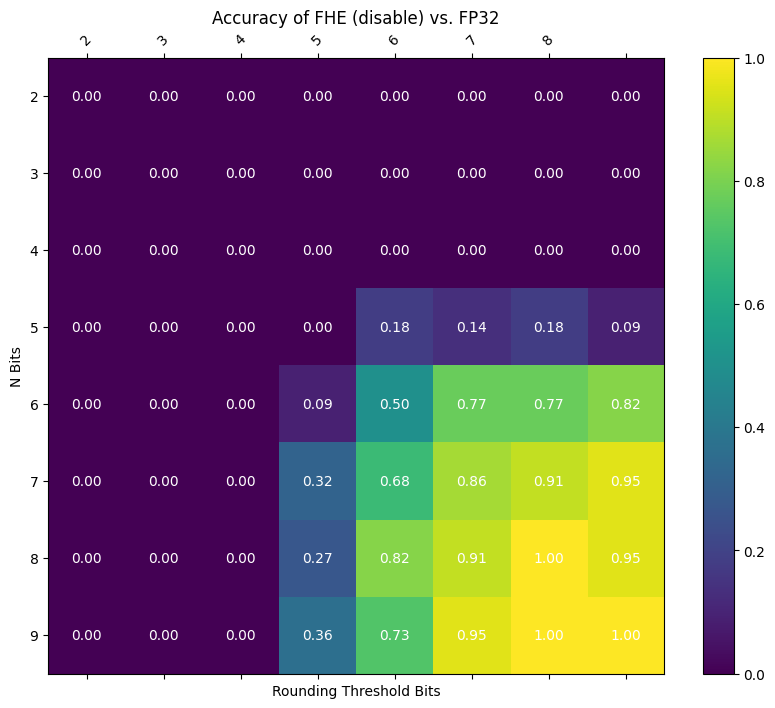

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from concrete.ml.torch.compile import build_quantized_module, compile_torch_model

def run_experiment(fhe_mode="disable"):
    # Assuming 'images' and 'resnet18' are already defined
    resnet18.eval()  # Set the model to inference mode

    # Define ranges for n_bits and rounding_threshold_bits
    n_bits_range = range(2, 10)  # 2 to 10
    rounding_threshold_bits_range = list(range(2, 9)) + [None]  # 2 to 9 and None

    # Initialize a dictionary to store accuracies for each combination
    accuracies = {}

    # Loop over the ranges of n_bits and rounding_threshold_bits
    for n_bits in n_bits_range:
        for rounding_threshold_bits in rounding_threshold_bits_range:
            compile_method = build_quantized_module if fhe_mode == "disable" else compile_torch_model
            q_module = compile_method(
                resnet18,
                torch_inputset=images,
                n_bits=n_bits,
                rounding_threshold_bits=rounding_threshold_bits,
            )

            with torch.no_grad():
                outputs_fhe = q_module.forward(images.detach().numpy(), fhe=fhe_mode)
                probabilities_fhe = torch.nn.functional.softmax(torch.from_numpy(outputs_fhe), dim=-1)
                outputs = resnet18(images)
                probabilities = torch.nn.functional.softmax(outputs, dim=-1)

            # Calculate and store accuracy
            fhe_accuracy_vs_fp32 = (
                (probabilities_fhe.argmax(-1) == probabilities.argmax(-1)).float().mean().item()
            )
            accuracies[(n_bits, rounding_threshold_bits)] = fhe_accuracy_vs_fp32

    # Convert accuracies to a 2D array for plotting
    accuracy_matrix = np.zeros((len(n_bits_range), len(rounding_threshold_bits_range)))
    for i, n_bits in enumerate(n_bits_range):
        for j, rounding_threshold_bits in enumerate(rounding_threshold_bits_range):
            accuracy_matrix[i, j] = accuracies[(n_bits, rounding_threshold_bits)]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    cax = ax.matshow(accuracy_matrix, cmap="viridis")
    fig.colorbar(cax)

    # Set ticks and labels
    ax.set_xticklabels([""] + rounding_threshold_bits_range, rotation=45)
    ax.set_yticklabels([""] + list(n_bits_range))
    ax.set_xlabel("Rounding Threshold Bits")
    ax.set_ylabel("N Bits")
    ax.set_title(f"Accuracy of FHE ({fhe_mode}) vs. FP32")

    # Annotate each cell with the accuracy percentage
    for i in range(len(n_bits_range)):
        for j in range(len(rounding_threshold_bits_range)):
            ax.text(j, i, f"{accuracy_matrix[i, j]:.2f}", va="center", ha="center", color="white")

    plt.show()



In [ ]:
run_experiment(fhe_mode="disable")

In [ ]:
run_experiment(fhe_mode="simulate")